# Import all the module

In [4]:
from ipywidgets import interact
from MPC2_phy_proj import *


test_env()

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.86381711e-11  0.00000000e+00  7.57322474e-11]
 [ 5.86381711e-11  0.00000000e+00 -7.57322474e-11]] [-0.6569052996153647, 0.32845264980768235, 0.32845264980768235]
Typical value is -8.66e-19 or -8.754e-19 J.
Total E= -8.753229796504332e-19


In [18]:
import math


def fibonacci_sphere(samples=1000):

    x_p = []
    y_p = []
    z_p = []
    
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        x_p.append(x)
        y_p.append(y)
        z_p.append(z)

    return x_p,y_p,z_p



def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)


   

def surf_sph(radius):
    x_p,y_p,z_p = fibonacci_sphere(samples=6) 
    if radius <= 0.5:
        mappedStart=0.5-radius
        mappedEnd=radius+0.5
        x_p_mapped = [0.5]
        for i in x_p:
            x_p_mapped.append(translate(i,-1,1,mappedStart,mappedEnd))
        y_p_mapped = [0.5]
        for i in y_p:
            y_p_mapped.append(translate(i,-1,1,mappedStart,mappedEnd))

        z_p_mapped = [0.5]
        for i in z_p:
            z_p_mapped.append(translate(i,-1,1,mappedStart,mappedEnd))
    else:
        print('Radius is too large')
    return x_p_mapped,y_p_mapped,z_p_mapped

# Define the constrain condition

## total_dist(...)

This funciton will caluculate the total distance between all the molecular pair, (mimic nC2)

In [2]:
def total_dist(ri):
    '''
    calculate the total distance between each pair of atoms
    '''
    tot_value=0 #initialise the total potential energy
    chargeadded=[] #list of indices of charges already added
    for loop in range(len(ri)): #loop over each charge in turn
        #....incomplete code below which you can use as a starting point
        for j in chargeadded: #loop over charges already added (bringing charge loop towards charge j)            
            tot_value_ij=dist(ri[j],ri[loop])
            #print('Adding PE %.2e [units] of bringing charge %d towards charge %d' % (Uij,loop,j))
            tot_value=tot_value+tot_value_ij
        chargeadded.append(loop) #add the index of the added charge to the list
    return tot_value 

## constrain01(...,...)

The function defines there is a miminum distance between each O-O pairs, usuall consider the hydrogen bond (approxi.2.4A~2.6A)

In [3]:
def constrain01(xyz_coord,threshold):
    chargeadded=[] #list of indices of charges already added
    bolean_list = []
    for loop in range(len(xyz_coord)): #loop over each charge in turn
        for j in chargeadded: #loop over charges already added (bringing charge loop towards charge j)            
            tot_value_ij=dist(xyz_coord[j],xyz_coord[loop])
            if tot_value_ij>threshold:
                bolean_list.append(True)
            else:
                bolean_list.append(False)
        chargeadded.append(loop)
    
    for k in bolean_list:
        if k!=True:
            return False
    return True

# Generate the data set under constrain01(...,...)

The code cell bellow will generate the n --> range(n) coord. sets. and calculate all the successfully genetated sets under constrain01(...,...). It will also plot the lowest E_energy interactive diagram of the cardition cooridations of that atoms set.

__TWO IMPORTANT PARAMETER:__

__'for i in range(1000):'__: this n in 'range(n)' will decide how many coords sets will be generated.


__'O_O_mini_dist = 0.24 #unit in nm'__: FOr example, 0.24 here means the minimum distance beteween two OXYGEN atoms, usually regard to the hydrgen bond length. Unit in nm!

The lowest E_energy - potl_E_sum: -5.2956395845187775e-18 J


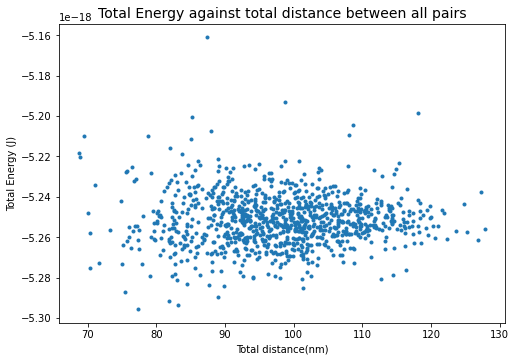

In [5]:
ditance_bw_all = []
total_E_all = []

datasets = []
#-------IMPORTANT-------BELOW-------O_O_mini_dist-------
O_O_mini_dist = 0.28 #unit in nm. 0.24 0.001
#-------IMPORTANT-------BELOW-------range(1000)-------
for i in range(1000):
    while True: # test the genrated coord. set, if dist bw O-O < O_O_mini_dist, regenate the coord. sets
        #inside the loop, generate another set
        xa=np.random.rand(6)
        ya=np.random.rand(6)
        za=np.random.rand(6)
        thetar=np.random.rand(6)*np.pi*2 
        phir=np.random.rand(6)*np.pi*2 
        moltypes =[1,1,1,1,1,1]
        xyza = np.stack((np.array(xa), np.array(ya),np.array(za)), axis=-1)

        #calculate the total E for this generated sys.
        rall,qall = allatomposns(moltypes,xa,ya,za,phir,thetar)
        rall = np.array(rall)*1e-9
        potl_E_sum = potl_energy_sum(rall,qall)

        if constrain01(xyza,O_O_mini_dist):
            break
        else:
            #regenerate, go to the start of the while loop           
            continue


    # then, use this generated coord, save the data
    rall,qall = allatomposns(moltypes,xa,ya,za,phir,thetar)
    datasets.append([moltypes,xa,ya,za,phir,thetar])# all the succeed coord. set is saved here
     
    #calculate the total distance
    ditance_bw_all.append(total_dist(rall))
    #calculate the total E_energy
    rall = np.array(rall)*1e-9
    potl_E_sum = potl_energy_sum(rall,qall)
    total_E_all.append(potl_E_sum)# all the total E_energy of the succeed coord. set are saved here

#------the coord. set finishing generating------
#for all the successfully generated coord. sets, find the lowest one
total_E_all = np.array(total_E_all)
datasets = np.array(datasets)
lowest_index = np.argmin(total_E_all)

# calculate the lowest energy 
rall,qall = allatomposns(datasets[lowest_index][0],datasets[lowest_index][1],datasets[lowest_index][2],\
                         datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
rall = np.array(rall)*1e-9
potl_E_sum = potl_energy_sum(rall,qall)
print('The lowest E_energy - potl_E_sum:',potl_E_sum, 'J')
    

#-------plot------Total E against total distance-------
#plot all the possible coord.
plt.figure(figsize=(8,5.5)) 
plt.title('Total Energy against total distance between all pairs',fontsize=14)
plt.plot(ditance_bw_all, total_E_all, marker='.',linestyle = '')

plt.xlabel('Total distance(nm)')
plt.ylabel('Total Energy (J)')
plt.show();

# Interactive：Version 1 （rcmd）

In [12]:
plotly_6woer(rall,qall)

potl_E_sum: -5.32e-18 J


# Interactive Version 2

In [6]:
#-------plot------3D-coord of the lowest E_energy-------
#plot the lowest E atoms posi.(interactive)
print('potl_E_sum:',potl_E_sum, 'J')

@interact
def make_plot_2(elevpara=(-27,90,3),azimpara=(-117,0,3)):
    f1,ax1 = mol_plot(moltypes,datasets[lowest_index][1],datasets[lowest_index][2],\
                      datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
    ax1.set_xlabel('x (nm)')
    ax1.set_ylabel('y (nm)')
    ax1.set_zlabel('z (nm)')
    ax1.set_title('molecule positions')
    ax1.set_aspect('auto')
    ax1.view_init(elev=elevpara, azim=azimpara) #adjust 'camera angle' with this command if desired - angles are in degrees
    f1.show();

potl_E_sum: -7.942363892148734e-18 J


interactive(children=(IntSlider(value=30, description='elevpara', max=90, min=-27, step=3), IntSlider(value=-6…

# Appendix: Try to find the system with energy below -8.0E-18 J -- Need RUNNING AFTER RUNNING '2'

## The cell right below is to find the sys. with O-O distance > <O_O_mini_dist> and total e_energy < -8.0E-18 J

The lowest E_energy - potl_E_sum: -5.935657423811837e-18 J


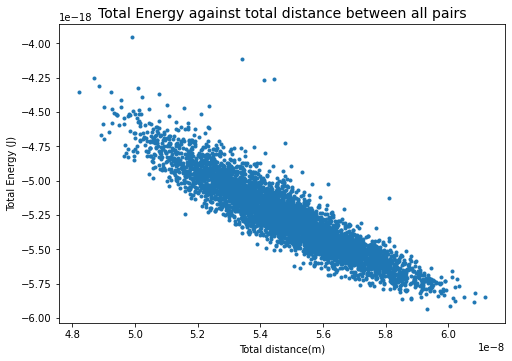

In [19]:
ditance_bw_all = []
total_E_all = []

datasets = []
#-------IMPORTANT-------BELOW-------O_O_mini_dist-------
O_O_mini_dist = 0.28 #unit in nm. 0.22

#-------IMPORTANT-------BELOW-------range(1000)-------
for i in range(5000):
    while True: # test the genrated coord. set, if dist bw O-O < O_O_mini_dist, regenate the coord. sets
        #inside the loop, generate another set

        xa,ya,za = surf_sph(0.23)
        
        thetar=np.random.rand(7)*np.pi*2 
        phir=np.random.rand(7)*np.pi*2 
 
        moltypes =[2,1,1,1,1,1,1]
        
        xyza = np.stack((np.array(xa), np.array(ya),np.array(za)), axis=-1)
        
        #calculate the total E for this generated sys.
        rall,qall = allatomposns(moltypes,xa,ya,za,phir,thetar)
        rall = np.array(rall)*1e-9
        potl_E_sum = potl_energy_sum(rall,qall)

        #if constrain01(xyza,O_O_mini_dist) and potl_E_sum < -5.27e-18:
        if potl_E_sum < -5.2e-19:
            break
        else:
            #regenerate, go to the start of the while loop           
            continue

    # then, use this generated coord, save the data
    datasets.append([moltypes,xa,ya,za,phir,thetar])# all the succeed coord. set is saved here
     
    #calculate the total distance
    ditance_bw_all.append(total_dist(rall))
    #calculate the total E_energy
    total_E_all.append(potl_E_sum)# all the total E_energy of the succeed coord. set are saved here

#------the coord. set finishing generating------
#for all the successfully generated coord. sets, find the lowest one
total_E_all = np.array(total_E_all)
datasets = np.array(datasets)
lowest_index = np.argmin(total_E_all)

# calculate the lowest energy 
rall,qall = allatomposns(datasets[lowest_index][0],datasets[lowest_index][1],datasets[lowest_index][2],\
                         datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
rall = np.array(rall)*1e-9
potl_E_sum = potl_energy_sum(rall,qall)
print('The lowest E_energy - potl_E_sum:',potl_E_sum, 'J')
    

#-------plot------Total E against total distance-------
#plot all the possible coord.
plt.figure(figsize=(8,5.5)) 
plt.title('Total Energy against total distance between all pairs',fontsize=14)
plt.plot(ditance_bw_all, total_E_all, marker='.',linestyle = '')

plt.xlabel('Total distance(m)')
plt.ylabel('Total Energy (J)')
plt.show();

In [20]:
xall=[]
yall=[]
zall=[]
for i in range(int(len(rall))):
    xall.append(float(rall[i][0])*1e9)
    yall.append(float(rall[i][1])*1e9)
    zall.append(float(rall[i][2])*1e9)
#print('xall:',xall)


#-------plot------3D-coord of the lowest E_energy-------
#plot the lowest E atoms posi.(interactive)
fig = make_subplots()
O_atoms = go.Scatter3d(x=xall[::3], y=yall[::3], z=zall[::3],mode='markers',marker = {'color' : 'red'},name='Oxygen Atom')
H_atoms01 = go.Scatter3d(x=xall[1::3], y=yall[1::3], z=zall[1::3],mode='markers',marker = {'color' : 'blue'},name='Hydrogen Atom')
H_atoms02 = go.Scatter3d(x=xall[2::3], y=yall[2::3], z=zall[2::3],mode='markers',marker = {'color' : 'blue'},name='Hydrogen Atom')

fig.add_trace(O_atoms)
fig.add_trace(H_atoms01)
fig.add_trace(H_atoms02)

fig.update_layout(title_text=f'molecule positions (Total energy = {this_e} J)',title_x=0.5,width=800, height=600,scene_aspectmode='cube',
                scene = dict(
                xaxis_title='x (nm)',
                yaxis_title='y (nm)',
                zaxis_title='z (nm)',
                             )
                 )

fig.show()
this_e = "{:.3g}".format(potl_energy_sum(rall,qall))
print('potl_E_sum:',this_e, 'J')


'''title_here = 'potl_E_sum: '+this_e+ ' J'
#-------plot------3D-coord of the lowest E_energy-------
#plot the lowest E atoms posi.(interactive)
@interact
def make_plot_2(elevpara=(-27,90,3),azimpara=(-117,0,3)):
    f1,ax1 = mol_plot(moltypes,datasets[lowest_index][1],datasets[lowest_index][2],\
                      datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
    ax1.set_xlabel('x (nm)')
    ax1.set_ylabel('y (nm)')
    ax1.set_zlabel('z (nm)')
    ax1.set_title(title_here)
    ax1.set_aspect('auto')
    ax1.view_init(elev=elevpara, azim=azimpara) #adjust 'camera angle' with this command if desired - angles are in degrees
    f1.show();'''

potl_E_sum: -5.94e-18 J


"title_here = 'potl_E_sum: '+this_e+ ' J'\n#-------plot------3D-coord of the lowest E_energy-------\n#plot the lowest E atoms posi.(interactive)\n@interact\ndef make_plot_2(elevpara=(-27,90,3),azimpara=(-117,0,3)):\n    f1,ax1 = mol_plot(moltypes,datasets[lowest_index][1],datasets[lowest_index][2],                      datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])\n    ax1.set_xlabel('x (nm)')\n    ax1.set_ylabel('y (nm)')\n    ax1.set_zlabel('z (nm)')\n    ax1.set_title(title_here)\n    ax1.set_aspect('auto')\n    ax1.view_init(elev=elevpara, azim=azimpara) #adjust 'camera angle' with this command if desired - angles are in degrees\n    f1.show();"

In [43]:
this_e = "{:.3g}".format(potl_energy_sum(rall,qall))
print('potl_E_sum:',this_e, 'J')


title_here = 'potl_E_sum: '+this_e+ ' J'
#-------plot------3D-coord of the lowest E_energy-------
#plot the lowest E atoms posi.(interactive)
@interact
def make_plot_2(elevpara=(-27,90,3),azimpara=(-117,0,3)):
    f1,ax1 = mol_plot(moltypes,datasets[lowest_index][1],datasets[lowest_index][2],\
                      datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
    ax1.set_xlabel('x (nm)')
    ax1.set_ylabel('y (nm)')
    ax1.set_zlabel('z (nm)')
    ax1.set_title(title_here)
    ax1.set_aspect('auto')
    ax1.view_init(elev=elevpara, azim=azimpara) #adjust 'camera angle' with this command if desired - angles are in degrees
    f1.show();

potl_E_sum: -5.44e-18 J


interactive(children=(IntSlider(value=30, description='elevpara', max=90, min=-27, step=3), IntSlider(value=-6…

The lowest E_energy - potl_E_sum: -5.361600615024585e-18 J


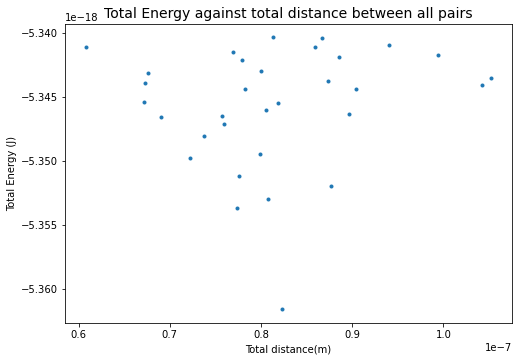

In [23]:
total_E_all = np.array(total_E_all)
datasets = np.array(datasets)
lowest_index = np.argmin(total_E_all)

# calculate the lowest energy 
rall,qall = allatomposns(datasets[lowest_index][0],datasets[lowest_index][1],datasets[lowest_index][2],\
                         datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
rall = np.array(rall)*1e-9
potl_E_sum = potl_energy_sum(rall,qall)
print('The lowest E_energy - potl_E_sum:',potl_E_sum, 'J')
    

#-------plot------Total E against total distance-------
#plot all the possible coord.
plt.figure(figsize=(8,5.5)) 
plt.title('Total Energy against total distance between all pairs',fontsize=14)
plt.plot(ditance_bw_all, total_E_all, marker='.',linestyle = '')

plt.xlabel('Total distance(m)')
plt.ylabel('Total Energy (J)')
plt.show();

## The cell right below is to plot the sys. which has the lowest energy under the condition defined above - using interactive: version 1

In [27]:
'potl_E_sum: '+this_e+ ' J'

'potl_E_sum: -5.36e-18 J'

In [28]:
#plot the interactive graphy
xall=[]
yall=[]
zall=[]
for i in range(int(len(rall))):
    xall.append(float(rall[i][0])*1e9)
    yall.append(float(rall[i][1])*1e9)
    zall.append(float(rall[i][2])*1e9)
#print('xall:',xall)
this_e = "{:.3g}".format(potl_energy_sum(rall,qall))
print('potl_E_sum:',this_e, 'J')


title_here = 'potl_E_sum: '+this_e+ ' J'
#-------plot------3D-coord of the lowest E_energy-------
#plot the lowest E atoms posi.(interactive)
@interact
def make_plot_2(elevpara=(-27,90,3),azimpara=(-117,0,3)):
    f1,ax1 = mol_plot(moltypes,datasets[lowest_index][1],datasets[lowest_index][2],\
                      datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
    ax1.set_xlabel('x (nm)')
    ax1.set_ylabel('y (nm)')
    ax1.set_zlabel('z (nm)')
    ax1.set_title(title_here)
    ax1.set_aspect('auto')
    ax1.view_init(elev=elevpara, azim=azimpara) #adjust 'camera angle' with this command if desired - angles are in degrees
    f1.show();

potl_E_sum: -5.36e-18 J


interactive(children=(IntSlider(value=30, description='elevpara', max=90, min=-27, step=3), IntSlider(value=-6…

## The cell below plot all the sys with the condition defiend in Code Cell 6.1.

The number of diagram will be the same as 'range(n)' in Code cell 6.1. __Causion: lagging computer__

In [58]:
# plot all the graphy for the sys with E lower than -8E-18 j
for lowest_index in range(len(datasets[:])):
    this_rall = []
    this_qall = []
    
    rall,qall = allatomposns(datasets[lowest_index][0],datasets[lowest_index][1],datasets[lowest_index][2],\
                         datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
    rall = np.array(rall)*1e-9
    potl_E_sum = potl_energy_sum(rall,qall)
    print('This E_energy - potl_E_sum:',potl_E_sum, 'J')

    
    
    this_e = "{:.3g}".format(potl_energy_sum(rall,qall))
    print('potl_E_sum:',this_e, 'J')


    '''    title_here = 'potl_E_sum: '+this_e+ ' J'
    #-------plot------3D-coord of the lowest E_energy-------
    #plot the lowest E atoms posi.(interactive)

    f1,ax1 = mol_plot(moltypes,datasets[lowest_index][1],datasets[lowest_index][2],\
                      datasets[lowest_index][3],datasets[lowest_index][4],datasets[lowest_index][5])
    ax1.set_xlabel('x (nm)')
    ax1.set_ylabel('y (nm)')
    ax1.set_zlabel('z (nm)')
    ax1.set_title(title_here)
    ax1.set_aspect('auto')
    ax1.view_init(elev=30, azim=-60) #adjust 'camera angle' with this command if desired - angles are in degrees
    f1.show()'''
    
    
    
    xall=[]
    yall=[]
    zall=[]
    for i in range(int(len(rall))):
        xall.append(float(rall[i][0])*1e9)
        yall.append(float(rall[i][1])*1e9)
        zall.append(float(rall[i][2])*1e9)
    #print('xall:',xall)
    this_e = "{:.3g}".format(potl_energy_sum(rall,qall))
    print('potl_E_sum:',this_e, 'J')

    #-------plot------3D-coord of the lowest E_energy-------
    #plot the lowest E atoms posi.(interactive)
    fig = make_subplots()
    O_atoms = go.Scatter3d(x=xall[::3], y=yall[::3], z=zall[::3],mode='markers',marker = {'color' : 'red'},name='Oxygen Atom')
    H_atoms01 = go.Scatter3d(x=xall[1::3], y=yall[1::3], z=zall[1::3],mode='markers',marker = {'color' : 'blue'},name='Hydrogen Atom')
    H_atoms02 = go.Scatter3d(x=xall[2::3], y=yall[2::3], z=zall[2::3],mode='markers',marker = {'color' : 'blue'},name='Hydrogen Atom')

    fig.add_trace(O_atoms)
    fig.add_trace(H_atoms01)
    fig.add_trace(H_atoms02)

    fig.update_layout(title_text=f'molecule positions (Total energy = {this_e} J)',title_x=0.5,width=800, height=600,scene_aspectmode='cube',
                    scene = dict(
                    xaxis_title='x (nm)',
                    yaxis_title='y (nm)',
                    zaxis_title='z (nm)',
                                 )
                     )

    fig.show()

    

This E_energy - potl_E_sum: -5.40370519804336e-18 J
potl_E_sum: -5.4e-18 J
potl_E_sum: -5.4e-18 J


This E_energy - potl_E_sum: -5.400027108296002e-18 J
potl_E_sum: -5.4e-18 J
potl_E_sum: -5.4e-18 J


This E_energy - potl_E_sum: -5.400219463916684e-18 J
potl_E_sum: -5.4e-18 J
potl_E_sum: -5.4e-18 J


This E_energy - potl_E_sum: -5.40040476345439e-18 J
potl_E_sum: -5.4e-18 J
potl_E_sum: -5.4e-18 J
